In [1]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sdcdup.utils import get_project_root
from sdcdup.utils import fuzzy_join
from sdcdup.utils import to_hls
from sdcdup.utils import channel_shift
from sdcdup.visualization import get_ticks

%load_ext dotenv
%dotenv

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

project_root = get_project_root()
train_image_dir = os.path.join(project_root, os.getenv('RAW_DATA_DIR'), 'train_768')
gimp_hls_dir = os.path.join(project_root, os.getenv('PERSISTENT_DATA_DIR'), 'gimp_hls')

ticks = get_ticks()

In [2]:
class ImgCmp:
    """
    Reads a saved copy of parent_hls, but that has been hls shifted by some value.
    The level of gain shifted and channel are encoded in the filename and parsed in the __init__.
    """

    def __init__(self, parent_hls, filename):
        
        self.filename = filename
        self.parent_prefix, self.img_id = filename.split('/')[-2:]
        self.gmp_prefix, self.gmp_extension = self.img_id.split('.')
        self.hls_channel, pom, gain = self.gmp_prefix[0], self.gmp_prefix[1], int(self.gmp_prefix[2:])
        sign = 1 if pom == 'p' else -1
        self.hls_gain = sign * gain

        self.parent_hls = parent_hls

        self._gmp_bgr = None
        self._gmp_hls = None
        self._gmp_rgb = None
        self._cv2_hls = None
        self._cv2_bgr = None
        self._cv2_rgb = None

    @property
    def gmp_bgr(self):
        if self._gmp_bgr is None:
            self._gmp_bgr = cv2.imread(self.filename)
        return self._gmp_bgr

    @property
    def gmp_hls(self):
        if self._gmp_hls is None:
            self._gmp_hls = self.to_hls(self.gmp_bgr)
        return self._gmp_hls

    @property
    def gmp_rgb(self):
        if self._gmp_rgb is None:
            self._gmp_rgb = self.to_rgb(self.gmp_bgr)
        return self._gmp_rgb

    @property
    def cv2_hls(self):
        if self._cv2_hls is None:
            self._cv2_hls = channel_shift(self.parent_hls, self.hls_channel, self.hls_gain)
        return self._cv2_hls

    @property
    def cv2_bgr(self):
        if self._cv2_bgr is None:
            self._cv2_bgr = self.to_bgr(self.cv2_hls)
        return self._cv2_bgr

    @property
    def cv2_rgb(self):
        if self._cv2_rgb is None:
            self._cv2_rgb = self.to_rgb(self.cv2_bgr)
        return self._cv2_rgb

    def to_hls(self, bgr):
        return cv2.cvtColor(bgr, cv2.COLOR_BGR2HLS_FULL)

    def to_bgr(self, hls):
        return cv2.cvtColor(hls, cv2.COLOR_HLS2BGR_FULL)

    def to_rgb(self, bgr):
        return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


In [3]:
def plot_row(ax, row_num, rgb1, title1, rgb2, title2):

    diff = fuzzy_join(rgb1, rgb2)
    rgb3 = diff / diff.max()
    title3 = f'mean: {np.mean(diff):>7.3f}, std: {np.std(diff):>7.3f}'
    
    ax[row_num, 0].imshow(rgb1)
    ax[row_num, 0].set_title(title1)
    ax[row_num, 0].set_xticks(ticks)
    ax[row_num, 0].set_yticks(ticks)
    ax[row_num, 1].imshow(rgb2)
    ax[row_num, 1].set_title(title2)
    ax[row_num, 1].set_xticks(ticks)
    ax[row_num, 1].set_yticks(ticks)
    ax[row_num, 2].imshow(rgb3)
    ax[row_num, 2].set_title(title3)
    ax[row_num, 2].set_xticks(ticks)
    ax[row_num, 2].set_yticks(ticks)

In [4]:
src1 = '03a5fd8d2.jpg'
src2 = '676f4cfd0.jpg'

ibgr1 = cv2.imread(os.path.join(train_image_dir, src1))
ibgr2 = cv2.imread(os.path.join(train_image_dir, src2))

ihls1 = to_hls(ibgr1)
ihls2 = to_hls(ibgr2)

irgb1 = cv2.cvtColor(ibgr1, cv2.COLOR_BGR2RGB)
irgb2 = cv2.cvtColor(ibgr2, cv2.COLOR_BGR2RGB)

# Hue

In [ ]:
modkeysA = [
    'Hm180.jpg', 
    'Hm135.jpg', 
    'Hm090.jpg', 
    'Hm045.jpg', 
    'Hm009.jpg', 
]
modkeysB = [
    'Hp009.jpg',
    'Hp045.jpg', 
    'Hp090.jpg', 
    'Hp135.jpg', 
    'Hp180.jpg', 
]

# Lightness

In [ ]:
modkeysA = [
    'Lm100.jpg', 
    'Lm075.jpg', 
    'Lm050.jpg', 
    'Lm025.jpg', 
]
modkeysB = [
    'Lp025.jpg',
    'Lp050.jpg', 
    'Lp075.jpg',
    'Lp100.jpg', 
]

# Saturation

In [5]:
modkeysA = [
    'Sm100.jpg', 
    'Sm075.jpg', 
    'Sm050.jpg', 
    'Sm025.jpg',
]
modkeysB = [
    'Sp025.jpg',
    'Sp050.jpg', 
    'Sp075.jpg', 
    'Sp100.jpg', 
]

# Brightness

In [ ]:
modkeysA = [
    'Bm127.jpg', 
    'Bm063.jpg', 
]
modkeysB = [
    'Bp063.jpg', 
    'Bp127.jpg', 
]

In [6]:
modsA = {k: ImgCmp(ihls1, os.path.join(gimp_hls_dir, f'03a5fd8d2/{k}')) for k in modkeysA}
modsB = {k: ImgCmp(ihls1, os.path.join(gimp_hls_dir, f'03a5fd8d2/{k}')) for k in modkeysB}

gain       cv2      gimp
-100  29266203  29238987
 -75  21975794  21542658
 -50  14525438  14841930
 -25   7127697   7663329
   0  21647457
  25   7588350   7045374
  50  14987954  14047082
  75  22306038  21458050
 100  29615303  29251394


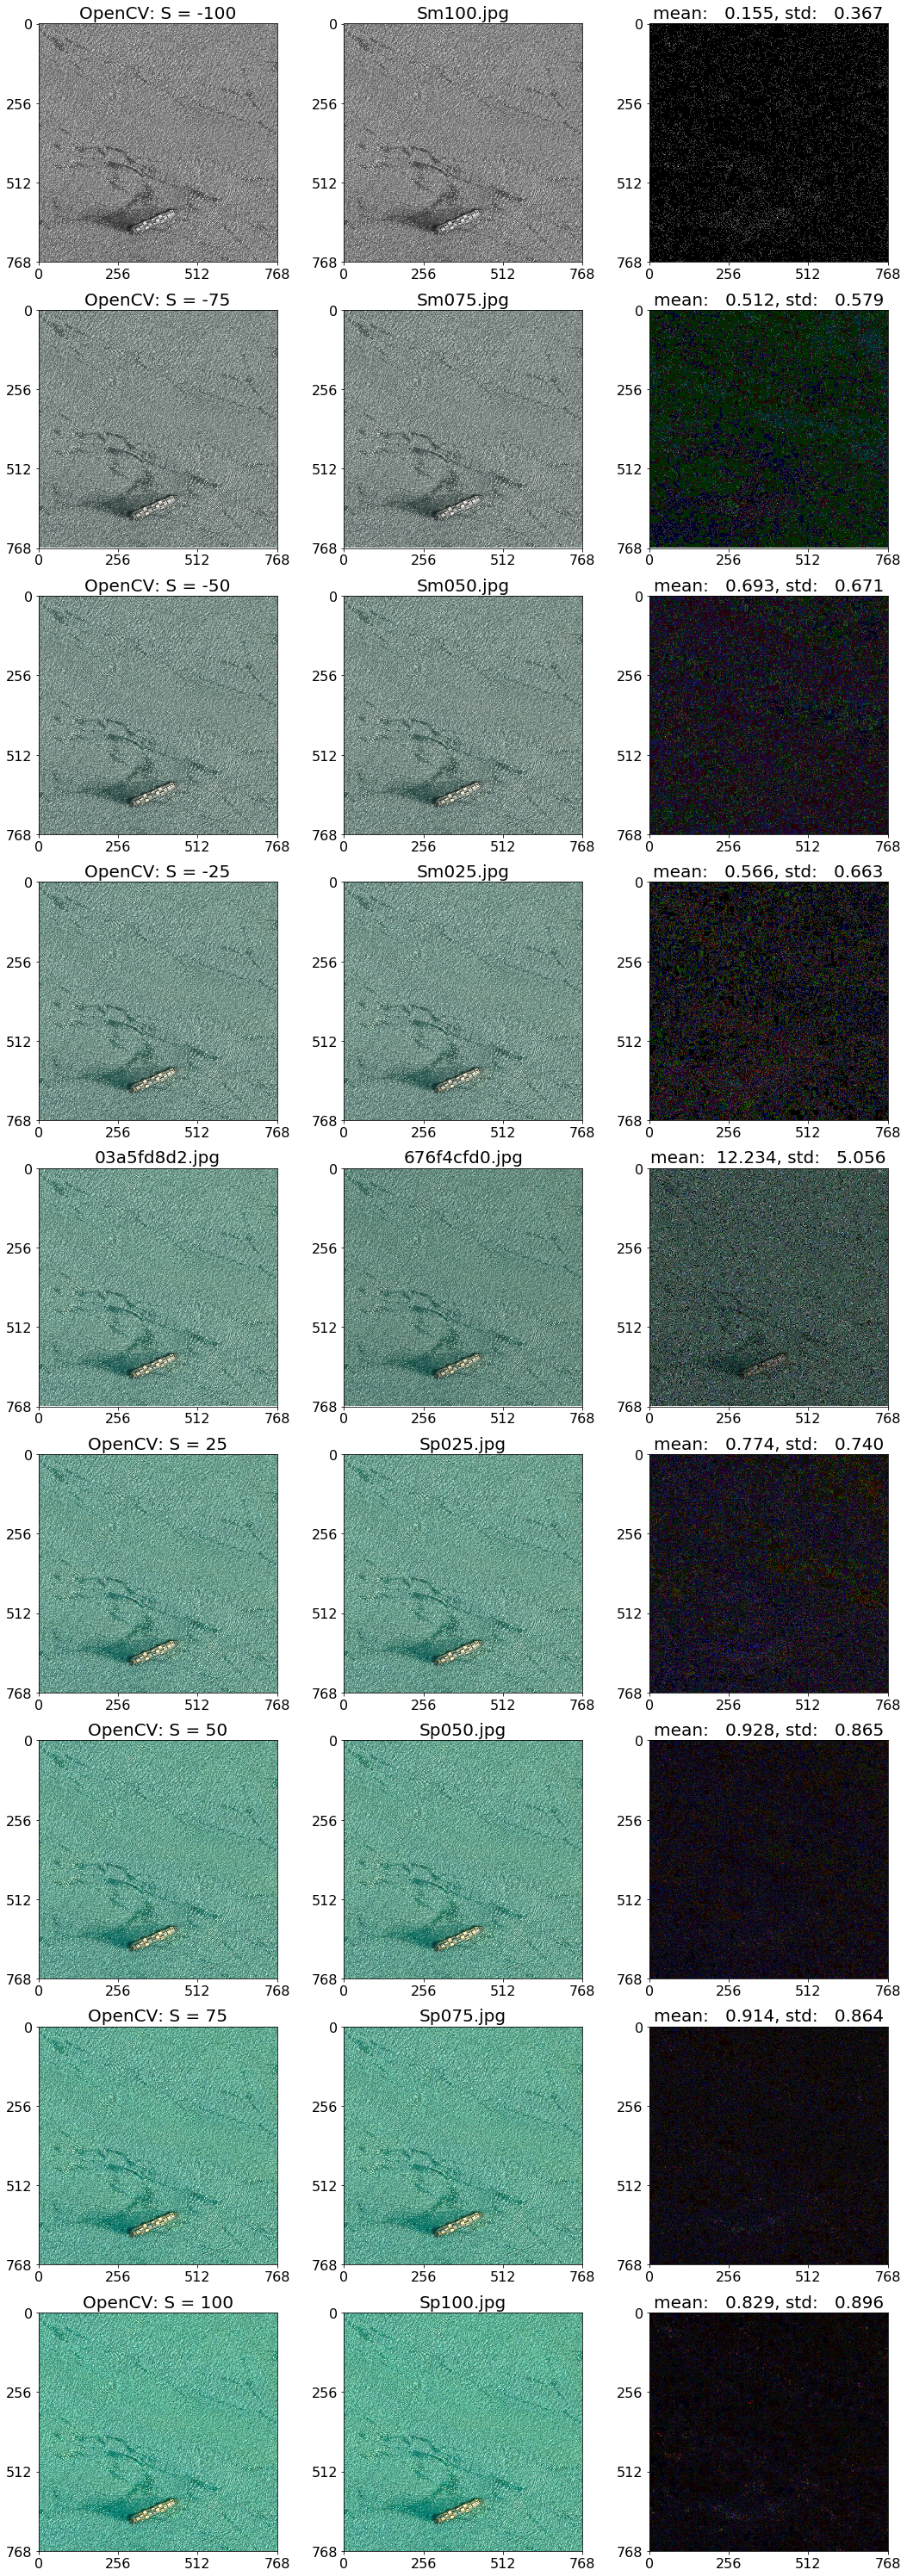

In [7]:
cv2_str = 'cv2'
gimp_str = 'gimp'
print(f'gain {cv2_str:>9} {gimp_str:>9}')
for k in modkeysA:
    cv2_val = np.sum(fuzzy_join(ibgr1, modsA[k].cv2_bgr))
    gmp_val = np.sum(fuzzy_join(ibgr1, modsA[k].gmp_bgr))
    print(f'{modsA[k].hls_gain:>4} {cv2_val:>9} {gmp_val:>9}')
print(f'{0:>4} {np.sum(fuzzy_join(ibgr1, ibgr2)):>9}')
for k in modkeysB:
    cv2_val = np.sum(fuzzy_join(ibgr1, modsB[k].cv2_bgr))
    gmp_val = np.sum(fuzzy_join(ibgr1, modsB[k].gmp_bgr))
    print(f'{modsB[k].hls_gain:>4} {cv2_val:>9} {gmp_val:>9}')
    
n_rows = len(modkeysA) + 1 + len(modkeysB)
fig, ax = plt.subplots(n_rows, 3, figsize=(3*6, n_rows*6))

ii = 0
for k in modkeysA:
#     plot_row(ax, ii, irgb1, src1, modsA[k].cv2_rgb, f'OpenCV: {modsA[k].hls_channel} = {modsA[k].hls_gain}')
#     ii += 1
#     plot_row(ax, ii, irgb1, src1, modsA[k].gmp_rgb, modsA[k].img_id)
#     ii += 1
    plot_row(ax, ii, modsA[k].cv2_rgb, f'OpenCV: {modsA[k].hls_channel} = {modsA[k].hls_gain}', modsA[k].gmp_rgb, modsA[k].img_id)
    ii += 1
plot_row(ax, ii, irgb1, src1, irgb2, src2)
ii += 1
for k in modkeysB:
#     plot_row(ax, ii, irgb1, src1, modsB[k].cv2_rgb, f'OpenCV: {modsB[k].hls_channel} = {modsB[k].hls_gain}')
#     ii += 1
#     plot_row(ax, ii, irgb1, src1, modsB[k].gmp_rgb, modsB[k].img_id)
#     ii += 1
    plot_row(ax, ii, modsB[k].cv2_rgb, f'OpenCV: {modsB[k].hls_channel} = {modsB[k].hls_gain}', modsB[k].gmp_rgb, modsB[k].img_id)
    ii += 1
plt.show()

# Extra

In [ ]:
print_minmax = lambda x: print(x.dtype, np.min(x, axis=(0, 1)), np.max(x, axis=(0, 1)))

In [ ]:
for k in modkeysA:
    print_minmax(modsA[k].gmp_hls)
print_minmax(ihls1)
for k in modkeysB:
    print_minmax(modsB[k].gmp_hls)

In [ ]:
for k in modkeysA:
    print_minmax(modsA[k].cv2_hls)
print_minmax(ihls1)
for k in modkeysB:
    print_minmax(modsB[k].cv2_hls)

In [ ]:
def show_pixel(row, col, s_pix, src_type='gimp'):
    if src_type == 'gimp':
        for k in modkeysA:
            print(f'{modsA[k].hls_gain:>4}', modsA[k].gmp_hls[row, col, :])
        print(f'{0:>4}', ihls1[row, col, :], '<----', s_pix)
        for k in modkeysB:
            print(f'{modsB[k].hls_gain:>4}', modsB[k].gmp_hls[row, col, :])
    elif src_type == 'cv2':
        for k in modkeysA:
            print(f'{modsA[k].hls_gain:>4}', modsA[k].cv2_hls[row, col, :])
        print(f'{0:>4}', ihls1[row, col, :], '<----', s_pix)
        for k in modkeysB:
            print(f'{modsB[k].hls_gain:>4}', modsB[k].cv2_hls[row, col, :])
    else:
        print("Please set src_type to one of ['gimp', 'cv2']")

In [ ]:
pix_ctr = Counter()
for i in range(768):
    for j in range(768):
        t = tuple(ihls1[i, j])
        pix_ctr[t] += 1

most_common_pix = pix_ctr.most_common()

In [ ]:
most_common_pix[0]

In [ ]:
np.argwhere(ihls1[..., 2] == 255)

In [ ]:
temp = [( 20, (628, 424)),
        ( 40, (767, 663)),
        ( 60, (767, 499)),
        ( 63, (767, 524)),
        ( 80, (  3, 178)),
        (100, (259, 370)),
        (120, (373, 207)),
        (127, (463, 243)),
        (140, (462, 258)),
        (160, (288, 516)),
        (180, (495, 224)),
        (190, (157, 313)),
        (191, (623, 389)),
        (200, (535, 642)),
        (210, (571, 337)),
        (220, (656, 344)),
        (230, (613, 435)),
        (255, (463, 367))]

for s_pix, (i, j) in temp:
    show_pixel(i, j, s_pix)
    print('')


In [ ]:
s230 = np.argwhere(np.all(ihls1[:, :, :-1] == (116, 206), axis=-1))

for i, j in s230:
    show_pixel(i, j, 111)
    print('')